# 📊 Group 35 – First Model Improvements

- Muhammad Bazaf Shakeel (26100146)
- Sulaiman Ahmad (26100350)

Welcome to the notebook for **Group 35**, where we document our initial efforts to improve a pretrained **ViCLIP model**, originally trained on the large-scale **InternVid-10M** video dataset.

---

###  Objective

Our goal is to **adapt and enhance ViCLIP’s performance** on a much **smaller, custom dataset** (~50 video-caption pairs, with potential expansion to ~1000).

---

###  In This Phase, We Explore:

1. **Fine-tuning** the full pretrained ViCLIP model on our dataset.
2. **Architectural modifications**, including:
   - Cross-Attention modules between modalities.
   - Custom loss functions to better handle ambiguous or semantically similar negative samples.

This notebook presents our experimental setup, model variants, training strategies, and an evaluation of their effectiveness.


### Initial Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/InternVid")

In [ ]:
%cd /content/drive/MyDrive/InternVid

/content/drive/MyDrive/InternVid


Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import torch
import torch.nn.functional as F
import random
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gc
import torch
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

try:
    from viclip import get_viclip, retrieve_text, _frame_from_video
except:
    from .viclip import get_viclip, retrieve_text, _frame_from_video

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


###  Model Configuration

We define the configuration for the pretrained ViCLIP model, specifying model size and checkpoint path.


In [ ]:
model_cfgs = {
    'viclip-b-internvid-10m-flt': {
        'size': 'l',
        'pretrained': 'viclip/ViClip-InternVid-10M-FLT.pth',
    }
}

### VideoCaptionDataset Class

We define a custom PyTorch `Dataset` to:
- Load video clips using OpenCV
- Extract frames using a chosen strategy
- Pair them with their corresponding captions from the dataset


In [ ]:
class VideoCaptionDataset(Dataset):
    def __init__(self, df, video_dir, frame_extractor):
        """
        df          : DataFrame with columns ['YoutubeID','Caption']
        video_dir   : path where <YoutubeID>.mp4 clips live
        frame_extractor: function to turn cv2.VideoCapture -> list of frames
        """
        self.df = df.reset_index(drop=True)
        self.video_dir = video_dir
        self.extract = frame_extractor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vid = row["YoutubeID"]
        cap = row["Caption"]

        # load frames
        path = os.path.join(self.video_dir, f"{vid}.mp4")
        video = cv2.VideoCapture(path)
        frames = [f for f in self.extract(video)]
        video.release()

        return frames, cap

## Cross-Attention Module

To improve modality interaction, we introduce a **Cross-Attention** mechanism between the video and text embeddings.  
This module uses a multi-head attention layer where one modality (e.g., vision) queries the other (e.g., text), allowing each to adaptively attend to features in the other.

Key features:
- Uses `nn.MultiheadAttention` for rich inter-modal interactions.
- Applies residual connection followed by Layer Normalization.
- Can be used symmetrically (video → text and text → video) during training.


In [ ]:
import torch.nn as nn

class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln = nn.LayerNorm(embed_dim)

    def forward(self, query, key_value):
        # Add sequence dimension if needed
        if query.dim() == 2:
            query = query.unsqueeze(1)
            key_value = key_value.unsqueeze(1)

        attn_output, _ = self.attn(query, key_value, key_value)
        return self.ln(query + attn_output).squeeze(1)

## Hard Negative-Aware Contrastive Loss (HNAC)

Standard contrastive losses treat all non-matching pairs equally as negatives. However, in video-text retrieval tasks, **false negatives** (semantically similar but unmatched captions) are common.

We address this by introducing **Hard Negative-Aware Contrastive Loss**, which:
- Applies a **soft weighting** to negative pairs based on similarity (harder negatives are down-weighted).
- Uses a decayed sigmoid function to modulate contrastive strength.
- Improves generalization by reducing over-penalization of potentially valid but unpaired samples.

This approach is especially useful in **low-data or noisy datasets** like ours.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HardNegativeAwareContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07, reduction='mean', hard_negative_weight=0.5):
        super().__init__()
        self.temperature = temperature
        self.reduction = reduction
        self.hard_negative_weight = hard_negative_weight

    def forward(self, video_embeddings, text_embeddings):
        """
        video_embeddings: (B, D)
        text_embeddings: (B, D)
        """
        batch_size = video_embeddings.size(0)


        video_norm = F.normalize(video_embeddings, dim=-1)
        text_norm = F.normalize(text_embeddings, dim=-1)

        sim_matrix = torch.matmul(video_norm, text_norm.T) / self.temperature

        pos_sim = torch.diag(sim_matrix)

        exp_sim = torch.exp(sim_matrix)

        weights_v2t = self._compute_negative_weights(video_norm, text_norm)

        mask = torch.eye(batch_size, device=sim_matrix.device).bool()
        exp_sim = exp_sim.masked_fill(mask, 0.0)
        weights_v2t = weights_v2t.masked_fill(mask, 0.0)


        denom_v2t = (exp_sim * weights_v2t + 1e-8).sum(dim=1)
        loss_v2t = -pos_sim + torch.log(denom_v2t + torch.exp(pos_sim))


        sim_matrix_t2v = sim_matrix.T
        pos_sim_t2v = torch.diag(sim_matrix_t2v)
        exp_sim_t2v = torch.exp(sim_matrix_t2v)
        weights_t2v = self._compute_negative_weights(text_norm, video_norm)
        weights_t2v = weights_t2v.masked_fill(mask, 0.0)
        exp_sim_t2v = exp_sim_t2v.masked_fill(mask, 0.0)
        denom_t2v = (exp_sim_t2v * weights_t2v + 1e-8).sum(dim=1)
        loss_t2v = -pos_sim_t2v + torch.log(denom_t2v + torch.exp(pos_sim_t2v))

        loss = (loss_v2t + loss_t2v) / 2

        if self.reduction == 'sum':
            return loss.sum()
        else:
            return loss.mean()

    def _compute_negative_weights(self, anchor, candidates):
        """
        Down-weight false negatives by applying a decay function on similarity.
        """
        sim_matrix = torch.matmul(anchor, candidates.T)

        weights = 1.0 - self.hard_negative_weight * torch.sigmoid(sim_matrix * 5)
        return weights.detach()

### Helper Functions

This section includes key utility functions used throughout training:

- **`normalize`**: Applies ImageNet-style normalization to image pixels.
- **`framestotensor`**: Converts a list of raw video frames to a properly shaped tensor `[1, T, C, H, W]` for ViCLIP input. Handles grayscale, RGBA, and missing frames robustly.
- **`clear_cuda`**: Frees GPU memory to avoid out-of-memory issues between runs.
- **`clip_loss`**: Computes a CLIP-style contrastive loss between video and text embeddings.
- **`custom_collate`**: A custom `collate_fn` for batching variable-length video frame sequences.


In [ ]:
v_mean = np.array([0.485, 0.456, 0.406]).reshape(1,1,3)
v_std = np.array([0.229, 0.224, 0.225]).reshape(1,1,3)

def normalize(data):
    return (data/255.0-v_mean)/v_std

def frames_to_tensor(vid_list, fnum=8, target_size=(224, 224), device=torch.device('cuda')):
    assert len(vid_list) >= fnum
    step = len(vid_list) // fnum
    vid_list = vid_list[::step][:fnum]

    fixed_list = []
    for x in vid_list:
        if x is None:
            x = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)
        elif len(x.shape) == 2:
            x = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
        elif x.shape[2] == 1:
            x = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
        elif x.shape[2] == 4:
            x = cv2.cvtColor(x, cv2.COLOR_RGBA2RGB)
        fixed_list.append(cv2.resize(x[:, :, ::-1], target_size))

    vid_tube = [np.expand_dims(normalize(x), axis=(0, 1)) for x in fixed_list]
    vid_tube = np.concatenate(vid_tube, axis=1)
    vid_tube = np.transpose(vid_tube, (0, 1, 4, 2, 3))
    vid_tube = torch.from_numpy(vid_tube).to(device, non_blocking=True).float()
    return vid_tube

def clear_cuda():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

def clip_loss(vision_embeds, text_embeds, temperature=0.07):
    if vision_embeds.ndim == 2 and text_embeds.ndim == 2:
        vision_embeds = F.normalize(vision_embeds, dim=-1)
        text_embeds = F.normalize(text_embeds, dim=-1)
        logits = (vision_embeds @ text_embeds.T) / temperature
        labels = torch.arange(len(logits)).to(logits.device)
        loss_i2t = F.cross_entropy(logits, labels)
        loss_t2i = F.cross_entropy(logits.T, labels)
        return (loss_i2t + loss_t2i) / 2
    else:
        raise ValueError("Embeddings must be 2D for contrastive loss.")

def custom_collate(batch):
    frames, captions = zip(*batch)
    return list(frames), list(captions)

### Loading DataFrames and Creating DataLoaders

We begin by reading the `aes.csv` file, which contains video-caption pairs.  
The dataset is split into training (80%), validation (10%), and test (10%) subsets using `train_test_split`.

We then initialize instances of the custom `VideoCaptionDataset`, which loads videos and extracts frames using `_frame_from_video`.

Finally, PyTorch `DataLoader`s are created for each dataset split, with a custom `collate_fn` to handle variable-length video inputs.


In [ ]:
aes_df = pd.read_csv("/content/drive/MyDrive/InternVid/aes.csv")

train_df, tmp_df = train_test_split(aes_df, test_size=0.2, random_state=42, shuffle=True)
val_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, shuffle=True)

In [ ]:
video_dir = "/content/drive/MyDrive/InternVid/Aes_InternVid_Clips"
train_ds = VideoCaptionDataset(train_df, video_dir, _frame_from_video)
val_ds   = VideoCaptionDataset(val_df,  video_dir, _frame_from_video)
test_ds  = VideoCaptionDataset(test_df,  video_dir, _frame_from_video)

print(f"Sizes of Datasets → Train: {len(train_ds)}, Validation: {len(val_ds)}, Test: {len(test_ds)}")

Sizes of Datasets → Train: 40, Validation: 5, Test: 5


In [ ]:
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  num_workers=0, collate_fn=custom_collate)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate)

### Training and Evaluation Loops

We define the core training and evaluation routines that support all architectural variants and loss functions explored in this notebook.

In [ ]:
# Training Loop
def train_epoch(model, loader, optimizer, loss_fn, cross_attn=None):
    model.train()
    total_loss = 0

    for frames_batch, captions in loader:
        optimizer.zero_grad()

        processed_batch = []
        for frames in frames_batch:
            processed = frames_to_tensor(frames, device=device)
            processed_batch.append(processed)

        vid_tensor = torch.cat(processed_batch, dim=0)
        vision_features = model.encode_vision(vid_tensor)
        text_features = model.encode_text(captions)

        if cross_attn:
          vision_features = cross_attn(vision_features, text_features)
          text_features = cross_attn(text_features, vision_features)

        loss = loss_fn(vision_features, text_features)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# Evaluating Loop
def evaluate(model, loader, loss_fn, cross_attn=None):
    model.eval()

    if not loss_fn:
        loss_fn = clip_loss

    total_loss = 0
    with torch.no_grad():
        for frames_batch, captions in loader:
            processed_batch = []
            for frames in frames_batch:
                processed = frames_to_tensor(frames, device=device)
                processed_batch.append(processed)

            vid_tensor = torch.cat(processed_batch, dim=0)
            vision_features = model.encode_vision(vid_tensor)
            text_features = model.encode_text(captions)

            if cross_attn:
              vision_features = cross_attn(vision_features, text_features)
              text_features = cross_attn(text_features, vision_features)



            loss = loss_fn(vision_features, text_features)

            if loss.dim() > 0:
                total_loss += loss.mean().item()
            else:
                total_loss += loss.item()

    return total_loss / len(loader)

### Training and Validation Runner

Handles the end-to-end training and validation loop over multiple epochs.

This function:
- Trains the model on the training set and evaluates it on the validation set for each epoch.
- Supports optional **Cross-Attention** modules during both training and validation.
- Uses the passed optimizer and loss function (InfoNCE or HNAC).
- Logs training and validation loss per epoch.
- Returns two lists capturing the loss trajectories, enabling comparison and visualization.

This is the main loop used by all experimental configurations.


In [ ]:
def train_and_evaluate_model(clip_model, optimizer, loss_fn, num_epochs, train_loader=train_loader, val_loader=val_loader, cross_attn=None):
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
      train_loss = train_epoch(clip_model, train_loader, optimizer, loss_fn=loss_fn, cross_attn=cross_attn)
      val_loss = evaluate(clip_model, val_loader, loss_fn=loss_fn, cross_attn=cross_attn)

      train_losses.append(train_loss)
      val_losses.append(val_loss)

      print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

  return train_losses, val_losses

### Model Instantiation & Training Wrapper

We define a flexible function `instantiate_and_train_model()` to streamline the experimentation process.

This function:
- **Loads the pretrained ViCLIP model** and moves it to the appropriate device.
- Optionally adds a **Cross-Attention module** based on `use_cross_attn`.
- Selects the appropriate **loss function**: standard InfoNCE or Hard Negative-Aware Contrastive Loss (HNAC).
- Unfreezes the vision encoder to allow full model fine-tuning.
- Trains the model using `train_and_evaluate_model()` for a specified number of epochs.
- Returns training and validation losses to facilitate performance comparison.

This modular wrapper makes it easy to toggle different configurations and directly compare their effectiveness.


In [ ]:
def instantiate_and_train_model(num_epochs, use_cross_attn, use_hnac_loss):
  clear_cuda()
  cfg = model_cfgs['viclip-b-internvid-10m-flt']
  model_dict = get_viclip(cfg['size'], cfg['pretrained'])
  clip_model = model_dict['viclip'].to(device)

  if use_cross_attn:
    cross_attn = CrossAttention(clip_model.embed_dim).to(device)
  else:
    cross_attn = None

  for p in clip_model.vision_encoder.parameters():
      p.requires_grad = True

  optimizer = torch.optim.AdamW(
      clip_model.parameters(),
      lr=2e-5,
      weight_decay=0.02
  )

  if use_hnac_loss:
    loss_fn = HardNegativeAwareContrastiveLoss(temperature=0.07, hard_negative_weight=0.5)
  else:
    loss_fn = clip_loss

  train_losses, val_losses = train_and_evaluate_model(clip_model, optimizer, loss_fn, num_epochs=20,
                                                                  train_loader=train_loader, val_loader=val_loader,
                                                                  cross_attn=cross_attn)

  return {'train_losses': train_losses, 'val_losses': val_losses}

### Instantiating the Default Model
We load the pretrained ViCLIP model and enable fine-tuning by unfreezing all model parameters. An AdamW optimizer is initialized with a small learning rate.

In [ ]:
cfg = model_cfgs['viclip-b-internvid-10m-flt']
model_dict = get_viclip(cfg['size'], cfg['pretrained'])
clip_default = model_dict['viclip'].to(device)

for p in clip_default.parameters():
    p.requires_grad = True

optimizer_default = torch.optim.AdamW(
    clip_default.parameters(),
    lr=2e-5,
    weight_decay=0.02
)

### Baseline Evaluation with Pretrained Weights

Before applying any improvements, we evaluate the base ViCLIP model on the validation set. This serves as a reference point to assess the impact of subsequent fine-tuning and architecture modifications.


In [ ]:
separator = "-"*50 + "\n"

print(separator)
print("Results Without Fine-Tuning\n")
print(separator)

eval_results = evaluate(clip_default, val_loader, clip_loss)
print(f"Validation Loss: {eval_results['loss']:.4f}\n")
print(separator)

--------------------------------------------------

Results Without Fine-Tuning

--------------------------------------------------

Validation Loss: 0.1719

--------------------------------------------------
 



## Fine-tuning ViCLIP on the Original Architecture

We fine-tune the entire ViCLIP model using both:
- Standard InfoNCE contrastive loss
- Hard-Negative Aware Contrastive Loss (HNAC)

This helps assess the baseline model’s capacity to adapt to a smaller dataset.


In [ ]:
results = {'Default with InfoNCE Loss': {}, 'Default with HNAC Loss': {},
           'Cross Attention with InfoNCE Loss': {}, 'Cross Attention with HNAC Loss': {}}

In [ ]:
results['Default with InfoNCE Loss'] = instantiate_and_train_model(num_epochs=20, use_cross_attn=False, use_hnac_loss=False)

Epoch 1/20 — Train Loss: 0.1744, Validation Loss: 0.0877
Epoch 2/20 — Train Loss: 0.0643, Validation Loss: 0.0754
Epoch 3/20 — Train Loss: 0.0924, Validation Loss: 0.0536
Epoch 4/20 — Train Loss: 0.0591, Validation Loss: 0.0567
Epoch 5/20 — Train Loss: 0.0122, Validation Loss: 0.0982
Epoch 6/20 — Train Loss: 0.0088, Validation Loss: 0.0941
Epoch 7/20 — Train Loss: 0.0393, Validation Loss: 0.0738
Epoch 8/20 — Train Loss: 0.0050, Validation Loss: 0.0461
Epoch 9/20 — Train Loss: 0.0045, Validation Loss: 0.0680
Epoch 10/20 — Train Loss: 0.0017, Validation Loss: 0.0658
Epoch 11/20 — Train Loss: 0.0388, Validation Loss: 0.0662
Epoch 12/20 — Train Loss: 0.0504, Validation Loss: 0.0626
Epoch 13/20 — Train Loss: 0.0505, Validation Loss: 0.0639
Epoch 14/20 — Train Loss: 0.0022, Validation Loss: 0.0563
Epoch 15/20 — Train Loss: 0.0050, Validation Loss: 0.0786
Epoch 16/20 — Train Loss: 0.0012, Validation Loss: 0.0663
Epoch 17/20 — Train Loss: 0.0012, Validation Loss: 0.0988
Epoch 18/20 — Train Los

In [ ]:
results['Default with HNAC Loss'] = instantiate_and_train_model(num_epochs=20, use_cross_attn=False, use_hnac_loss=True)

Epoch 1/20 — Train Loss: 0.1963, Validation Loss: 0.1129
Epoch 2/20 — Train Loss: 0.0677, Validation Loss: 0.0922
Epoch 3/20 — Train Loss: 0.0582, Validation Loss: 0.0887
Epoch 4/20 — Train Loss: 0.0240, Validation Loss: 0.0680
Epoch 5/20 — Train Loss: 0.0242, Validation Loss: 0.0704
Epoch 6/20 — Train Loss: 0.0190, Validation Loss: 0.0698
Epoch 7/20 — Train Loss: 0.0174, Validation Loss: 0.0627
Epoch 8/20 — Train Loss: 0.0410, Validation Loss: 0.0714
Epoch 9/20 — Train Loss: 0.0133, Validation Loss: 0.0714
Epoch 10/20 — Train Loss: 0.0106, Validation Loss: 0.0741
Epoch 11/20 — Train Loss: 0.0089, Validation Loss: 0.0785
Epoch 12/20 — Train Loss: 0.0334, Validation Loss: 0.0594
Epoch 13/20 — Train Loss: 0.0096, Validation Loss: 0.0704
Epoch 14/20 — Train Loss: 0.0434, Validation Loss: 0.0651
Epoch 15/20 — Train Loss: 0.0126, Validation Loss: 0.0709
Epoch 16/20 — Train Loss: 0.0086, Validation Loss: 0.0614
Epoch 17/20 — Train Loss: 0.0088, Validation Loss: 0.0655
Epoch 18/20 — Train Los

## Modifying the Architecture: Cross-Attention Integration

We experiment with integrating a **Cross-Attention** module between video and text embeddings. This allows the model to better capture inter-modal relationships. We again try both loss functions to observe the benefit.


In [ ]:
results['Cross Attention with InfoNCE Loss'] = instantiate_and_train_model(num_epochs=20, use_cross_attn=True, use_hnac_loss=False)

Epoch 1/20 — Train Loss: 0.3011, Validation Loss: 0.1578
Epoch 2/20 — Train Loss: 0.0587, Validation Loss: 0.1301
Epoch 3/20 — Train Loss: 0.0635, Validation Loss: 0.1159
Epoch 4/20 — Train Loss: 0.1392, Validation Loss: 0.1601
Epoch 5/20 — Train Loss: 0.0624, Validation Loss: 0.1170
Epoch 6/20 — Train Loss: 0.0505, Validation Loss: 0.1097
Epoch 7/20 — Train Loss: 0.0093, Validation Loss: 0.1280
Epoch 8/20 — Train Loss: 0.0439, Validation Loss: 0.0844
Epoch 9/20 — Train Loss: 0.0111, Validation Loss: 0.0749
Epoch 10/20 — Train Loss: 0.0078, Validation Loss: 0.0844
Epoch 11/20 — Train Loss: 0.0073, Validation Loss: 0.0864
Epoch 12/20 — Train Loss: 0.1276, Validation Loss: 0.0813
Epoch 13/20 — Train Loss: 0.0098, Validation Loss: 0.0922
Epoch 14/20 — Train Loss: 0.0080, Validation Loss: 0.0780
Epoch 15/20 — Train Loss: 0.0111, Validation Loss: 0.0957
Epoch 16/20 — Train Loss: 0.0056, Validation Loss: 0.0824
Epoch 17/20 — Train Loss: 0.0038, Validation Loss: 0.0560
Epoch 18/20 — Train Los

In [ ]:
results['Cross Attention with HNAC Loss'] = instantiate_and_train_model(num_epochs=20, use_cross_attn=True, use_hnac_loss=True)

Epoch 1/20 — Train Loss: 0.2832, Validation Loss: 0.1197
Epoch 2/20 — Train Loss: 0.0857, Validation Loss: 0.0856
Epoch 3/20 — Train Loss: 0.0551, Validation Loss: 0.0682
Epoch 4/20 — Train Loss: 0.0846, Validation Loss: 0.0748
Epoch 5/20 — Train Loss: 0.0108, Validation Loss: 0.0806
Epoch 6/20 — Train Loss: 0.0560, Validation Loss: 0.0698
Epoch 7/20 — Train Loss: 0.0171, Validation Loss: 0.0835
Epoch 8/20 — Train Loss: 0.0088, Validation Loss: 0.0521
Epoch 9/20 — Train Loss: 0.0291, Validation Loss: 0.0550
Epoch 10/20 — Train Loss: 0.0555, Validation Loss: 0.0684
Epoch 11/20 — Train Loss: 0.0539, Validation Loss: 0.0421
Epoch 12/20 — Train Loss: 0.0274, Validation Loss: 0.0760
Epoch 13/20 — Train Loss: 0.0250, Validation Loss: 0.0564
Epoch 14/20 — Train Loss: 0.0053, Validation Loss: 0.0481
Epoch 15/20 — Train Loss: 0.0033, Validation Loss: 0.0564
Epoch 16/20 — Train Loss: 0.0066, Validation Loss: 0.0424
Epoch 17/20 — Train Loss: 0.0453, Validation Loss: 0.0530
Epoch 18/20 — Train Los

## Results Visualization

We plot training and validation losses across epochs for all four experimental setups:
- Default + InfoNCE
- Default + HNAC
- Cross Attention + InfoNCE
- Cross Attention + HNAC

These graphs allow us to compare the effectiveness of each improvement quantitatively.


In [ ]:
results = {'Default with InfoNCE Loss': {'train_losses': [0.1744, 0.0643, 0.0924, 0.0591, 0.0122, 0.0088, 0.0393, 0.005, 0.0045, 0.0017, 0.0388, 0.0504, 0.0505, 0.0022, 0.005, 0.0012, 0.0012, 0.0511, 0.0021, 0.0014], 'val_losses': [0.0877, 0.0754, 0.0536, 0.0567, 0.0982, 0.0941, 0.0738, 0.0461, 0.068, 0.0658, 0.0662, 0.0626, 0.0639, 0.0563, 0.0786, 0.0663, 0.0988, 0.0707, 0.0997, 0.1134]}, 'Default with HNAC Loss': {'train_losses': [0.1963, 0.0677, 0.0582, 0.024, 0.0242, 0.019, 0.0174, 0.041, 0.0133, 0.0106, 0.0089, 0.0334, 0.0096, 0.0434, 0.0126, 0.0086, 0.0088, 0.0068, 0.0104, 0.0558], 'val_losses': [0.1129, 0.0922, 0.0887, 0.068, 0.0704, 0.0698, 0.0627, 0.0714, 0.0714, 0.0741, 0.0785, 0.0594, 0.0704, 0.0651, 0.0709, 0.0614, 0.0655, 0.0738, 0.0682, 0.0522]}, 'Cross Attention with InfoNCE Loss': {'train_losses': [0.3011, 0.0587, 0.0635, 0.1392, 0.0624, 0.0505, 0.0093, 0.0439, 0.0111, 0.0078, 0.0073, 0.1276, 0.0098, 0.008, 0.0111, 0.0056, 0.0038, 0.0048, 0.0745, 0.0379], 'val_losses': [0.1578, 0.1301, 0.1159, 0.1601, 0.117, 0.1097, 0.128, 0.0844, 0.0749, 0.0844, 0.0864, 0.0813, 0.0922, 0.078, 0.0957, 0.0824, 0.056, 0.0903, 0.0643, 0.0835]}, 'Cross Attention with HNAC Loss': {'train_losses': [0.2832, 0.0857, 0.0551, 0.0846, 0.0108, 0.056, 0.0171, 0.0088, 0.0291, 0.0555, 0.0539, 0.0274, 0.025, 0.0053, 0.0033, 0.0066, 0.0453, 0.0595, 0.0038, 0.0052], 'val_losses': [0.1197, 0.0856, 0.0682, 0.0748, 0.0806, 0.0698, 0.0835, 0.0521, 0.055, 0.0684, 0.0421, 0.076, 0.0564, 0.0481, 0.0564, 0.0424, 0.053, 0.053, 0.054, 0.0412]}}

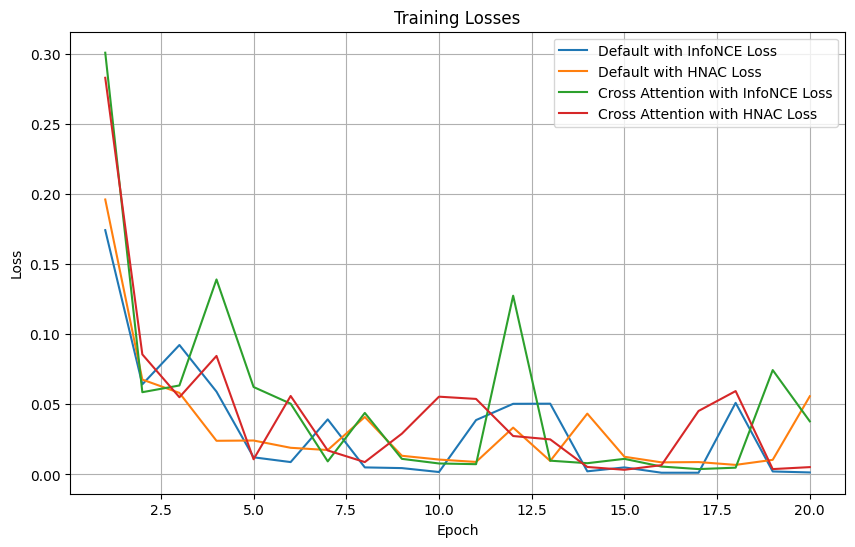

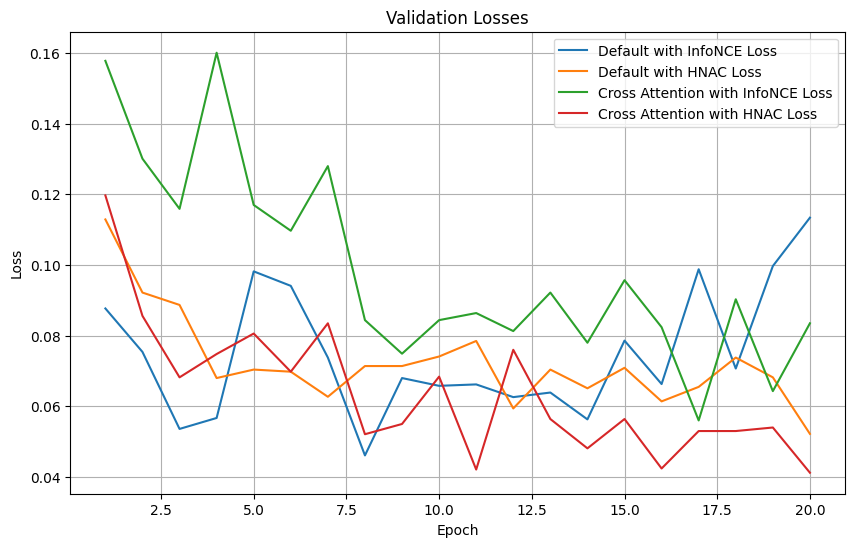

In [ ]:
num_epochs = len(list(results.values())[0]['train_losses'])
epochs = range(1, num_epochs + 1)

# Plotting training losses
plt.figure(figsize=(10, 6))
for technique, losses in results.items():
    plt.plot(epochs, losses['train_losses'], label=technique)
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting validation losses
plt.figure(figsize=(10, 6))
for technique, losses in results.items():
    plt.plot(epochs, losses['val_losses'], label=technique)
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualizing Performance: Default vs. Cross-Attention Architectures

We create a 2x2 grid of plots to compare **training** and **validation** losses for each architecture and loss combination:

- **Top Row**: Results using standard **InfoNCE** contrastive loss.
- **Bottom Row**: Results using **Hard Negative-Aware Contrastive Loss (HNAC)**.
- **Left Column**: Training losses across epochs.
- **Right Column**: Validation losses across epochs.

Each subplot compares:
- The **default ViCLIP model** (without architectural modifications).
- The **Cross-Attention-enhanced model** (allowing inter-modal feature refinement).

This visualization helps us evaluate the **effectiveness and stability** of each improvement in terms of loss reduction and generalization.


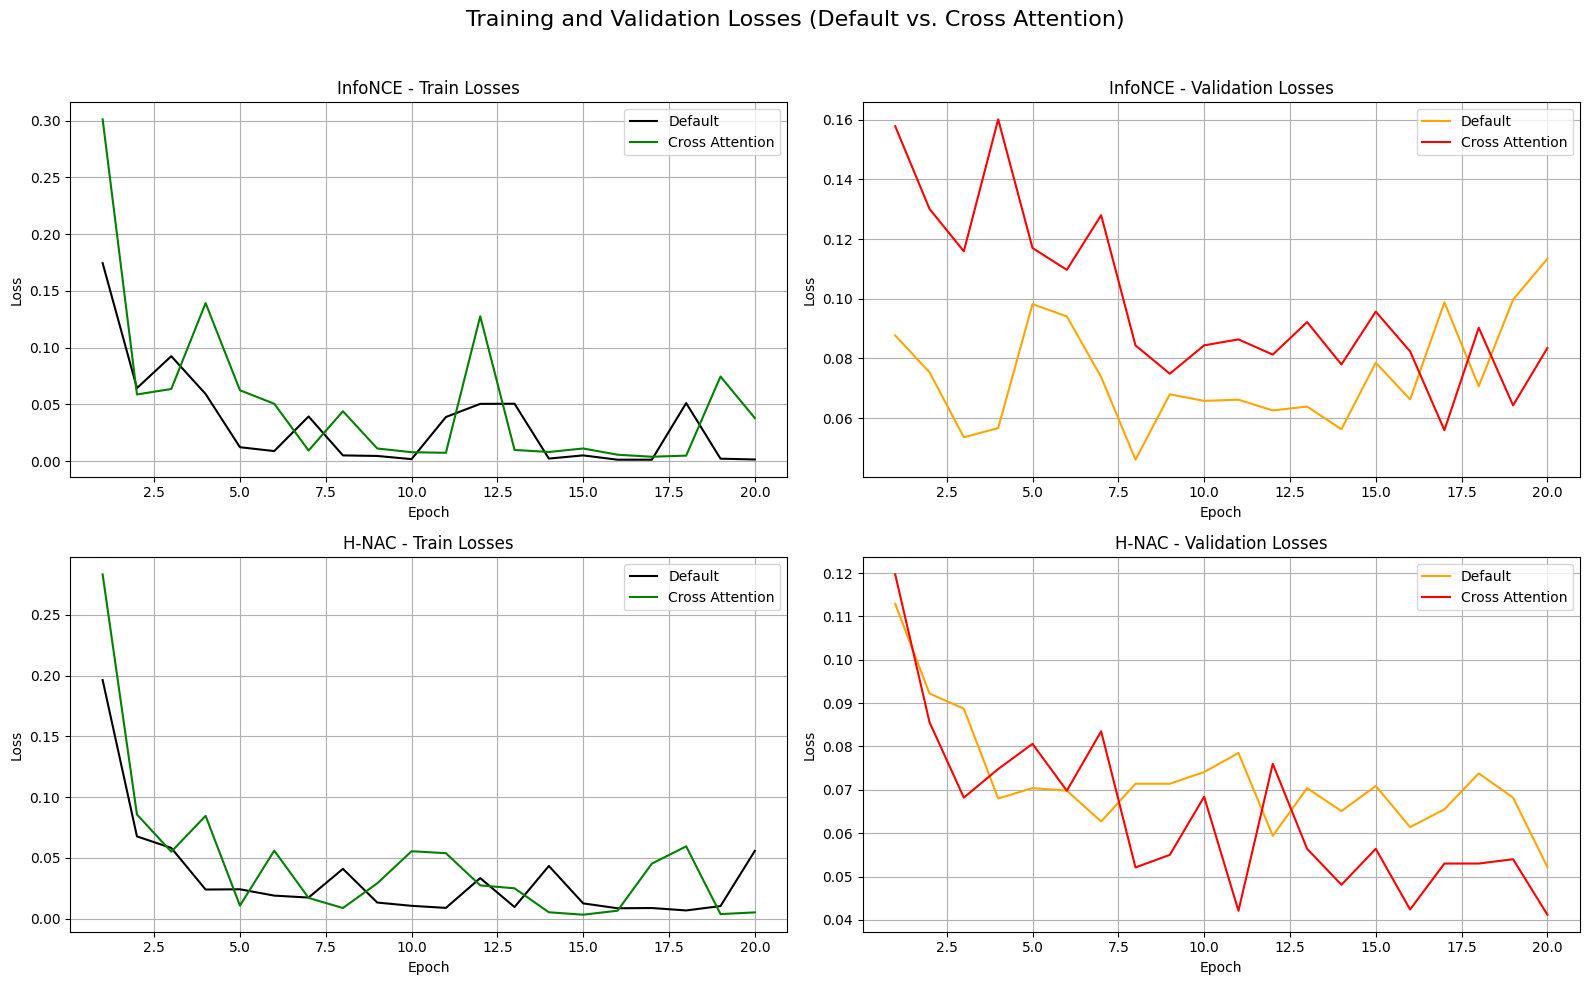

In [ ]:
num_epochs = len(next(iter(results.values()))['train_losses'])
epochs = range(1, num_epochs + 1)

# Set up 2x2 grid for plotting
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Training and Validation Losses (Default vs. Cross Attention)", fontsize=16)

# InfoNCE - Train
axs[0, 0].plot(epochs, results['Default with InfoNCE Loss']['train_losses'], label='Default', color='black')
axs[0, 0].plot(epochs, results['Cross Attention with InfoNCE Loss']['train_losses'], label='Cross Attention', color='green')
axs[0, 0].set_title('InfoNCE - Train Losses')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# InfoNCE - Val
axs[0, 1].plot(epochs, results['Default with InfoNCE Loss']['val_losses'], label='Default', color='orange')
axs[0, 1].plot(epochs, results['Cross Attention with InfoNCE Loss']['val_losses'], label='Cross Attention', color='red')
axs[0, 1].set_title('InfoNCE - Validation Losses')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# HNAC - Train
axs[1, 0].plot(epochs, results['Default with HNAC Loss']['train_losses'], label='Default', color='black')
axs[1, 0].plot(epochs, results['Cross Attention with HNAC Loss']['train_losses'], label='Cross Attention', color='green')
axs[1, 0].set_title('H-NAC - Train Losses')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()
axs[1, 0].grid(True)

# HNAC - Val
axs[1, 1].plot(epochs, results['Default with HNAC Loss']['val_losses'], label='Default', color='orange')
axs[1, 1].plot(epochs, results['Cross Attention with HNAC Loss']['val_losses'], label='Cross Attention', color='red')
axs[1, 1].set_title('H-NAC - Validation Losses')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Final Evaluation & Observations

After conducting experiments across four configurations of the ViCLIP model—varying both architectural changes (Cross-Attention) and loss functions (InfoNCE vs. HNAC)—we draw the following conclusions:

#### Summary of Results

| Configuration                         | Final Validation Loss | Best Validation Loss |
|--------------------------------------|------------------------|----------------------|
| Default + InfoNCE                    | 0.1134                 | **0.0461 (Epoch 8)** |
| Default + HNAC                       | **0.0522**                 | **0.0522 (Epoch 20)** ✅ |
| Cross-Attention + InfoNCE            | 0.0835                 | **0.0560 (Epoch 17)** |
| Cross-Attention + HNAC               | **0.0412**             | **0.0412 (Epoch 20)** ✅ |

#### Key Insights

- **Best Overall Performance:**  
  The **Cross-Attention with HNAC loss** consistently delivered the **lowest final and best validation losses**, indicating that the combination of enhanced modality interaction and hard negative awareness was most effective on this small-scale dataset.

- **Cross-Attention Effectiveness:**  
  Incorporating cross-attention between vision and text modalities improved performance for both InfoNCE and H-NAC objectives, demonstrating its value in enhancing inter-modal alignment.

- **Comparing Loss Functions:**
Both InfoNCE and H-NAC were effective, but they exhibit different characteristics: H-NAC tended to produce smoother validation curves and lower final losses, likely due to its robustness to hard negatives—especially important in limited data scenarios.

- **Overfitting in Default + InfoNCE:**  
  Despite sharp drops in training loss, the **default model with InfoNCE** exhibited signs of overfitting, with validation loss increasing in later epochs (e.g., 0.0461 → 0.1134), highlighting the limitations of using InfoNCE alone.

#### Conclusion

This phase demonstrates that **even small architectural and loss function improvements** can yield **substantial gains in performance** for pretrained models when adapting them to smaller, specialized datasets. The Cross-Attention + HNAC configuration will serve as the **baseline going into further improvements**.
